In [91]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [94]:
# subjects = np.arange(1,9)
subjects=[1]
n_subjects = len(subjects)

noise_levels = [0.00, 0.10, 0.20]

fitting_types = ['gabor_solo_ridge_12ori_8sf_simulated_gabor_addnoise_%.2f'%nn for nn in noise_levels]
out = [[load_fits.load_fit_results(subject=ss, fitting_type=ft, n_from_end=0, \
                                  verbose=False) for ss in subjects] for ft in fitting_types]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[0][si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# thresholding voxels based on their R2 for this model
r2_cutoff = 0.01
val_r2 = np.concatenate([out[0][si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

In [200]:
[[np.all(out[fi][si]['best_lambdas']==0) for si in range(n_subjects)] for fi in range(3)]

[[True], [False], [False]]

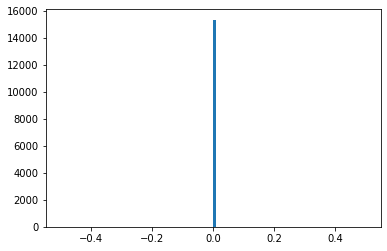

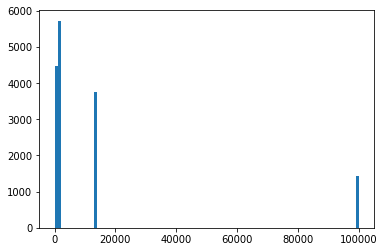

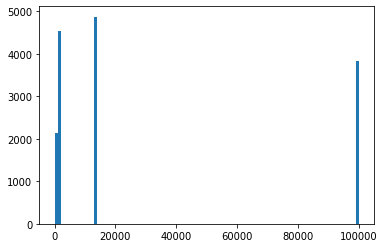

In [207]:
for fi in range(3):
    
    l = out[fi][0]['lambdas'][out[fi][0]['best_lambdas']]

    plt.figure()
    plt.hist(l,100);

In [205]:
np.all(l==0)

True

In [96]:
thing = '/user_data/mmhender/features/gabor_texture/simulated_data/S1_sim_data_addnoise_0.10.npy'
sim = np.load(thing, allow_pickle=True).item()
sim_prf_inds = sim['simulated_voxel_prf_inds']
assert(np.all(out[0][0]['best_params'][5][:,0]==sim_prf_inds))
sim_orient = sim['simulated_voxel_orient']
sim_sf = sim['simulated_voxel_sf']


In [98]:
prf_pars = out[0][0]['models'][sim_prf_inds,:].round(2)

#### Get info about the Gabor feature space

In [99]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


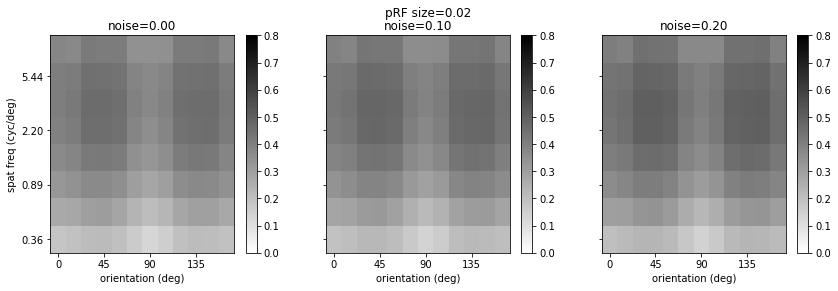

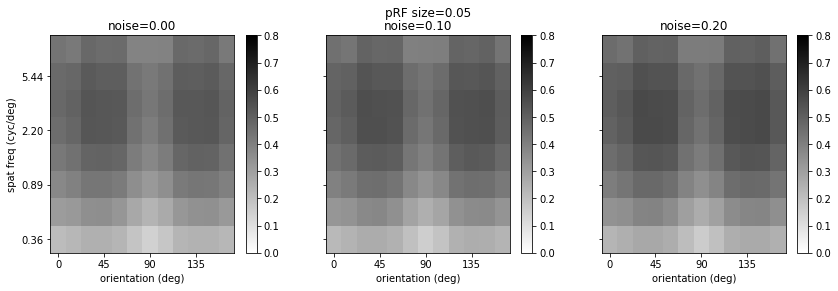

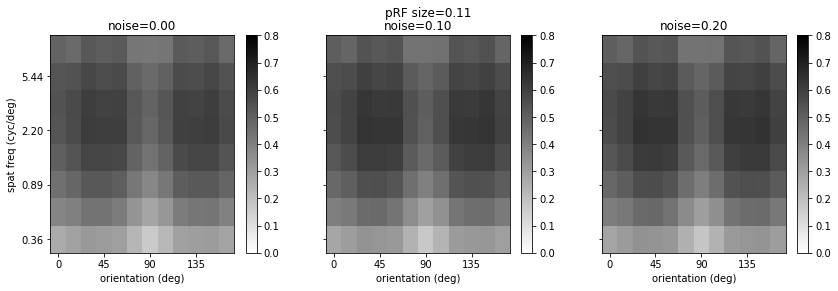

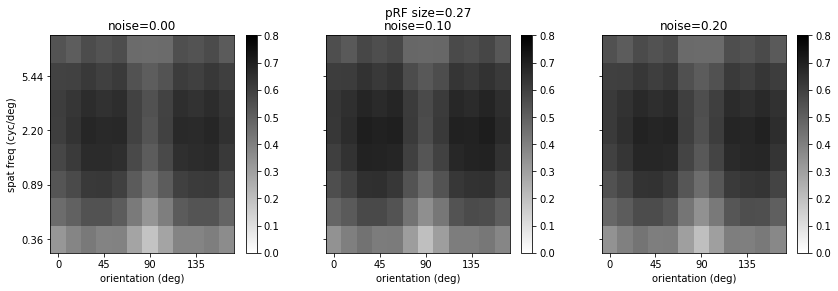

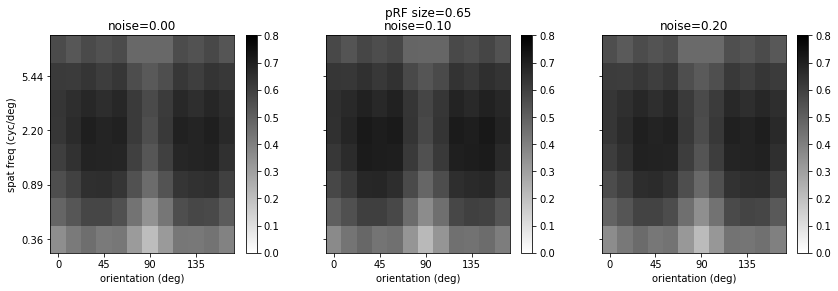

In [186]:
for size in np.unique(prf_pars[:,2]):

    vox_inds = prf_pars[:,2]==size

    plt.figure(figsize=(14,4))

    for fi, noise_level in enumerate(noise_levels):

        feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
        n_voxels = feature_corr.shape[0]
        allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
        
        plt.subplot(1,3,fi+1)
        # vals = 1-np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
        # plt.pcolormesh(vals, cmap='gray_r',vmin=0, vmax=1)
        vals = np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
        plt.pcolormesh(vals, cmap='gray_r',vmin=0, vmax=0.80)
        plt.colorbar()
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if fi==0:
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            plt.ylabel('spat freq (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5, [])
        plt.title('noise=%.2f'%noise_level)

    plt.suptitle('pRF size=%.2f'%(size))

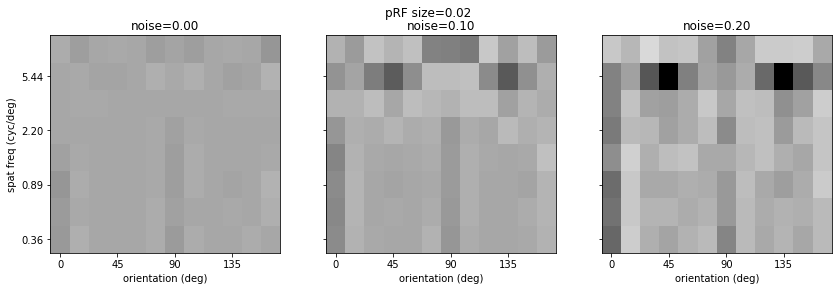

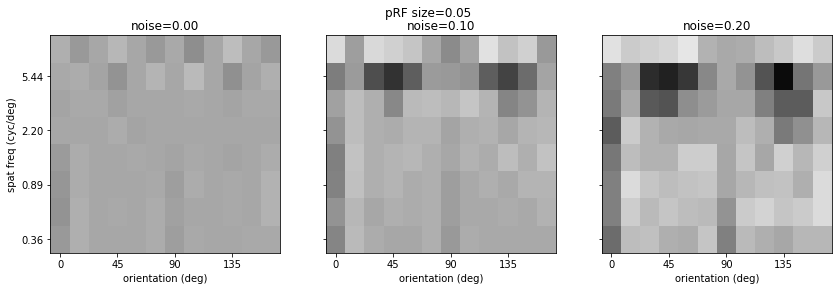

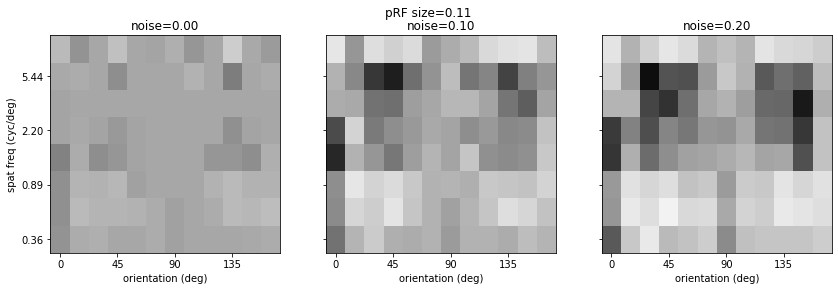

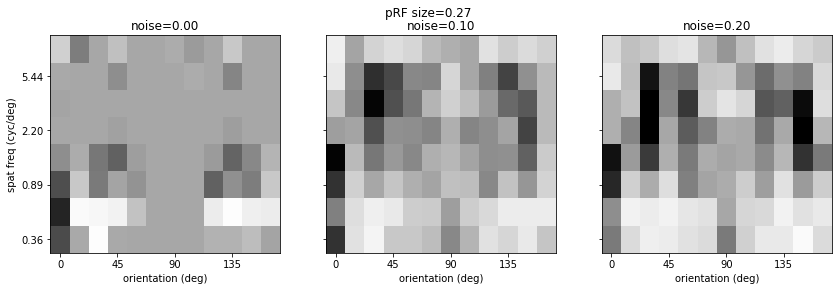

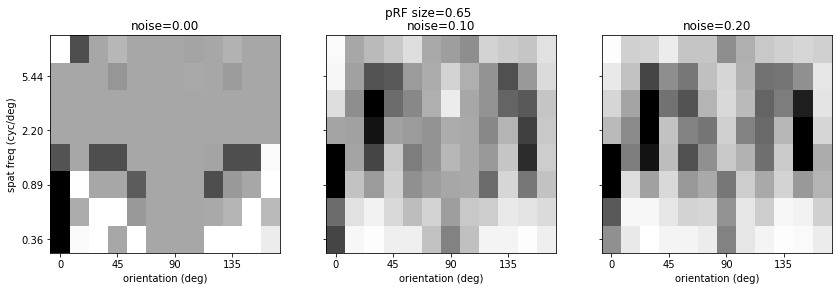

In [164]:
for size in np.unique(prf_pars[:,2]):

    vox_inds = prf_pars[:,2]==size

    plt.figure(figsize=(14,4))

    for fi, noise_level in enumerate(noise_levels):

        feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
        n_voxels = feature_corr.shape[0]
        allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
        mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
        mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

        # find maxes for orient/SF
        preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
        is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
        assert not np.any(is_constant)
        preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

        n_vox = preferred_ori_corr.shape[0]
        feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
        for vv in range(n_vox):
            oo = int(preferred_ori_corr[vv])
            ff = int(preferred_sf_corr[vv])
            feature_prefs_2dhist[vv,oo,ff] = 1


        plt.subplot(1,3,fi+1)
        vals = np.mean(feature_prefs_2dhist[vox_inds,:,:], axis=0).T
        plt.pcolormesh(vals, cmap='gray_r', vmin=0, vmax=0.03)
        # plt.colorbar()
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if fi==0:
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            plt.ylabel('spat freq (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5, [])
        plt.title('noise=%.2f'%noise_level)

    plt.suptitle('pRF size=%.2f'%(size))

In [172]:
fi = 0;

feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
assert not np.any(is_constant)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

n_vox = preferred_ori_corr.shape[0]
feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr[vv])
    ff = int(preferred_sf_corr[vv])
    feature_prefs_2dhist[vv,oo,ff] = 1

Text(0, 0.5, 'spat freq (cyc/deg)')

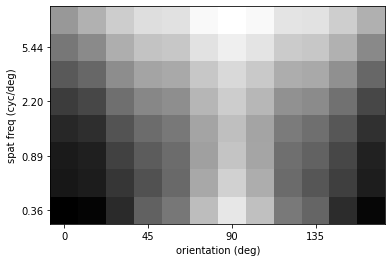

In [187]:
vox_inds = prf_pars[:,2]==size
vox_inds = vox_inds & (feature_prefs_2dhist[:,0,0]==1)

vals = np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
plt.pcolormesh(vals, cmap='gray_r')
plt.xlabel('orientation (deg)')
plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
plt.ylabel('spat freq (cyc/deg)')


Text(0, 0.5, 'spat freq (cyc/deg)')

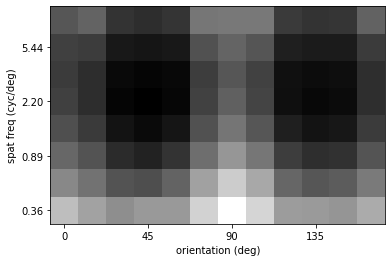

In [190]:
vox_inds = prf_pars[:,2]==size
vox_inds = vox_inds & (feature_prefs_2dhist[:,3,4]==1)

vals = np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
plt.pcolormesh(vals, cmap='gray_r')
plt.xlabel('orientation (deg)')
plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
plt.ylabel('spat freq (cyc/deg)')


In [175]:
sim_orient[vox_inds]

array([  0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15.,
       165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,
        15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,
         0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15.,
       165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,
        15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,
         0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15.,
       165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,
        15., 165.,   0.,  15., 165.,   0.,  15., 165.])

In [177]:
sim_sf[vox_inds]

array([0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714

#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

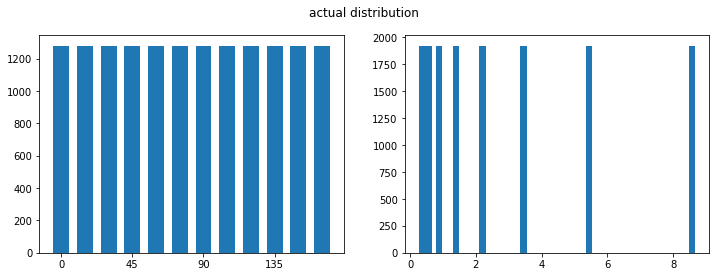

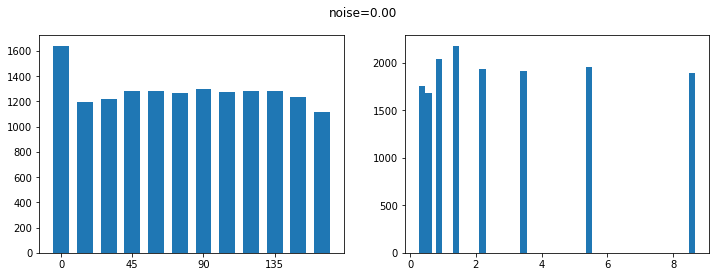

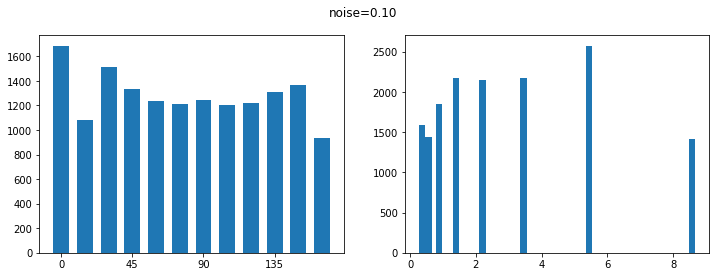

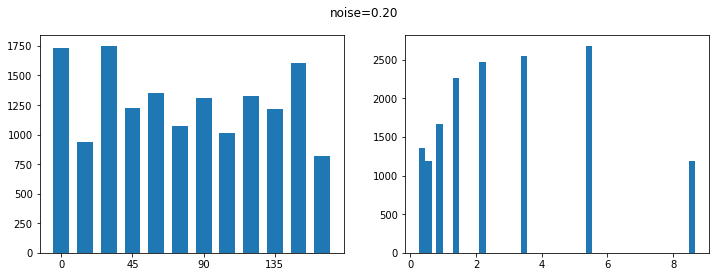

In [128]:
plt.figure(figsize=(12,4))
    
plt.subplot(1,2,1)
un, counts = np.unique(sim_orient, return_counts=True)
plt.bar(ori_unique, counts, width=10)
plt.xticks(np.arange(0,180,45))

plt.subplot(1,2,2)
un, counts = np.unique(sim_sf, return_counts=True)
plt.bar(sf_unique, counts, width=0.2)
plt.suptitle('actual distribution')

for fi, noise_level in enumerate(noise_levels):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
    assert not np.any(is_constant)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    un, counts = np.unique(preferred_ori_corr, return_counts=True)
    plt.bar(ori_unique, counts, width=10)
    plt.xticks(np.arange(0,180,45))
    
    plt.subplot(1,2,2)
    un, counts = np.unique(preferred_sf_corr, return_counts=True)
    plt.bar(sf_unique, counts, width=0.2)
    plt.suptitle('noise=%.2f'%noise_level)

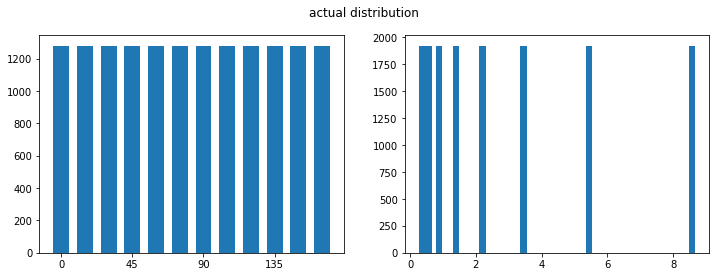

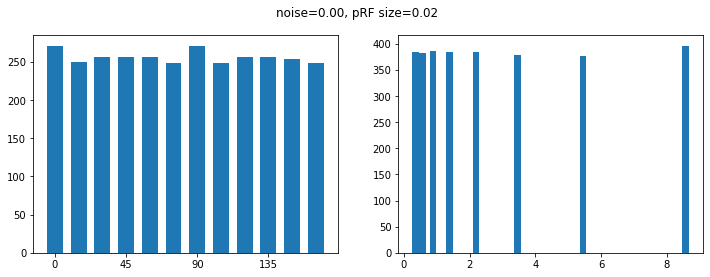

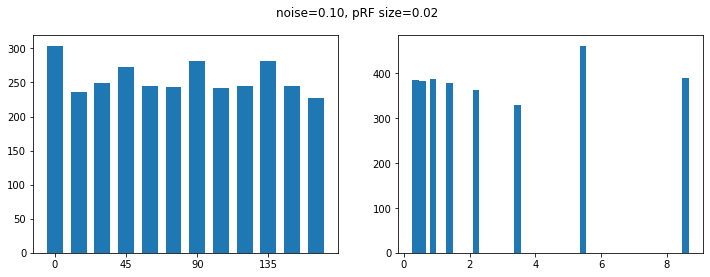

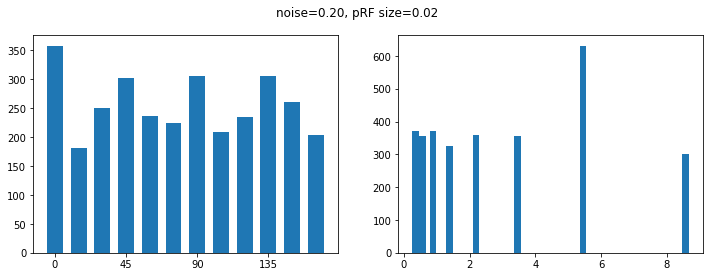

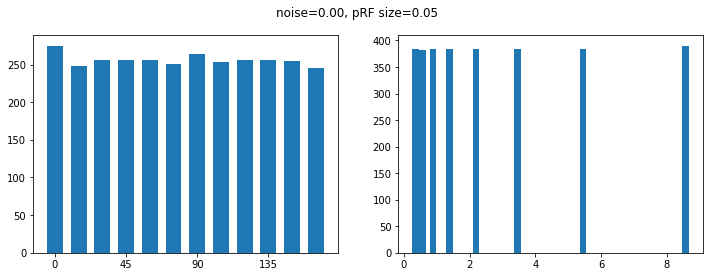

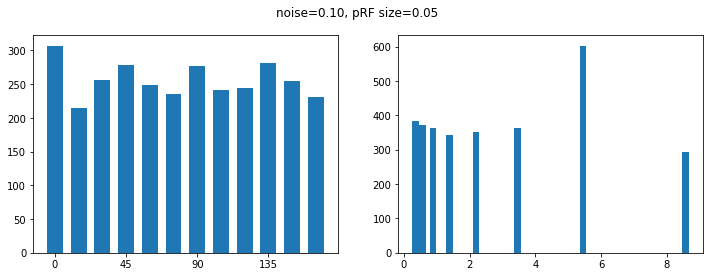

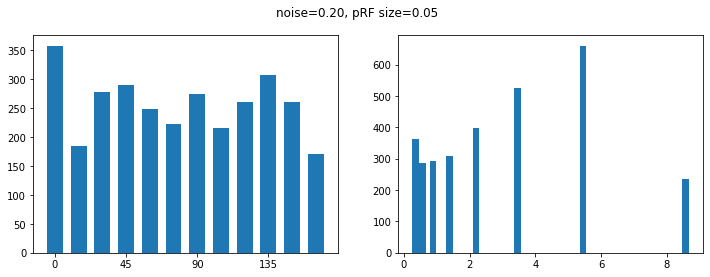

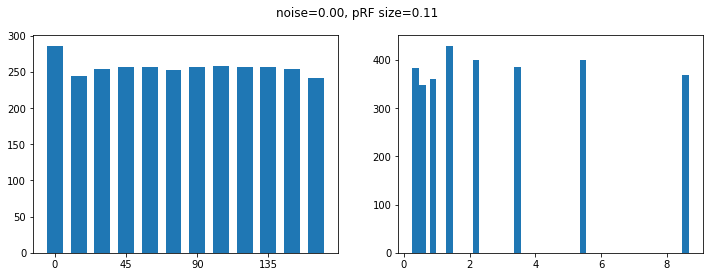

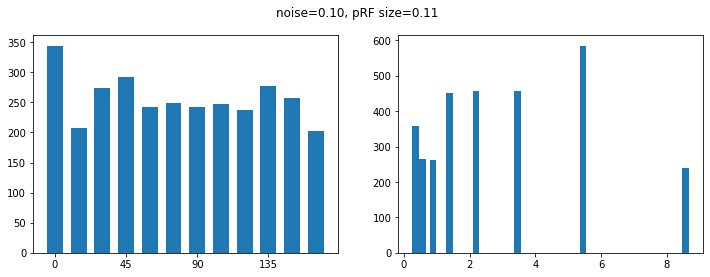

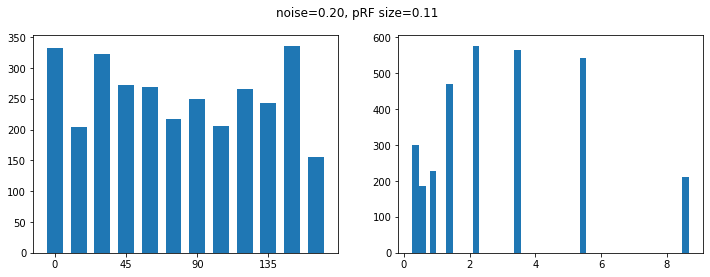

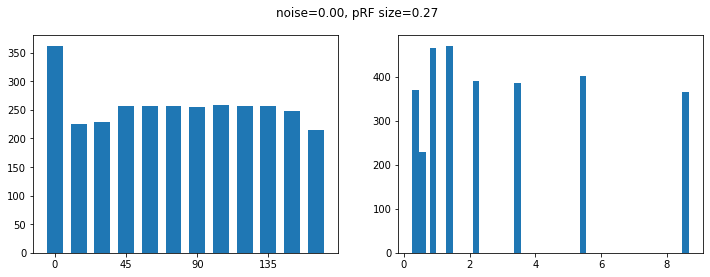

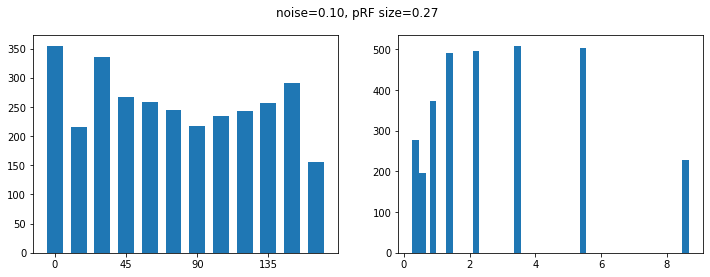

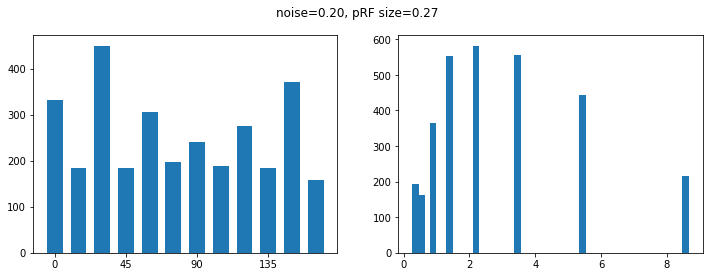

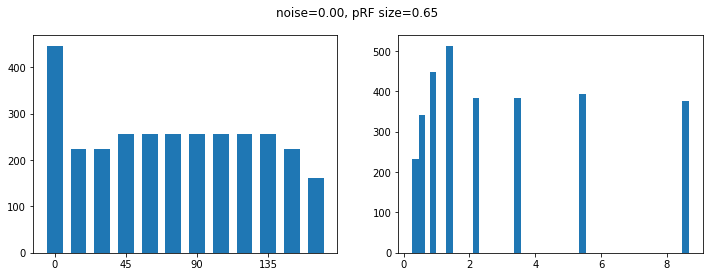

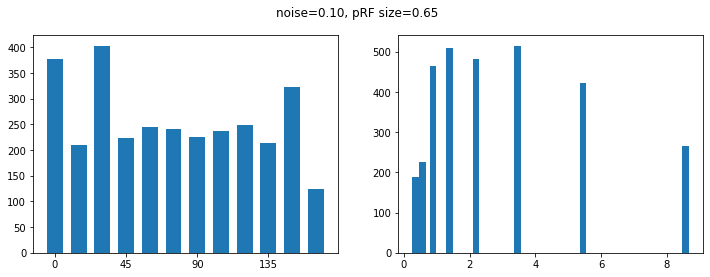

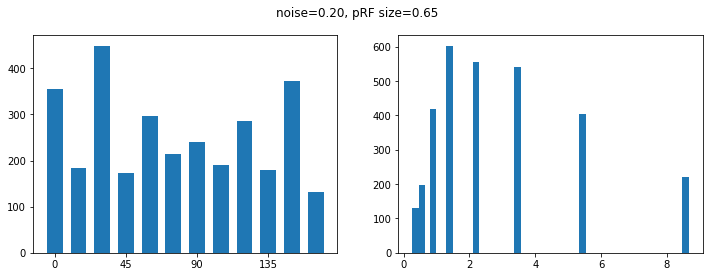

In [129]:
plt.figure(figsize=(12,4))
    
plt.subplot(1,2,1)
un, counts = np.unique(sim_orient, return_counts=True)
plt.bar(ori_unique, counts, width=10)
plt.xticks(np.arange(0,180,45))

plt.subplot(1,2,2)
un, counts = np.unique(sim_sf, return_counts=True)
plt.bar(sf_unique, counts, width=0.2)
plt.suptitle('actual distribution')

for size in np.unique(prf_pars[:,2]):

    vox_inds = prf_pars[:,2]==size

    for fi, noise_level in enumerate(noise_levels):

        feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
        n_voxels = feature_corr.shape[0]
        allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
        mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
        mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

        # find maxes for orient/SF
        preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
        is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
        assert not np.any(is_constant)
        preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        un, counts = np.unique(preferred_ori_corr[vox_inds], return_counts=True)
        plt.bar(ori_unique, counts, width=10)
        plt.xticks(np.arange(0,180,45))

        plt.subplot(1,2,2)
        un, counts = np.unique(preferred_sf_corr[vox_inds], return_counts=True)
        plt.bar(sf_unique, counts, width=0.2)
        plt.suptitle('noise=%.2f, pRF size=%.2f'%(noise_level, size))

In [130]:
np.unique(prf_pars[:,2])


array([0.02, 0.05, 0.11, 0.27, 0.65], dtype=float32)

In [137]:
sf_unique

array([0.35714286, 0.56236075, 0.88549892, 1.39431555, 2.19550336,
       3.45706178, 5.44352442, 8.57142857])

In [141]:
sf_unique*8.4

array([ 3.        ,  4.72383032,  7.43819096, 11.71225066, 18.44222825,
       29.03931899, 45.72560516, 72.        ])

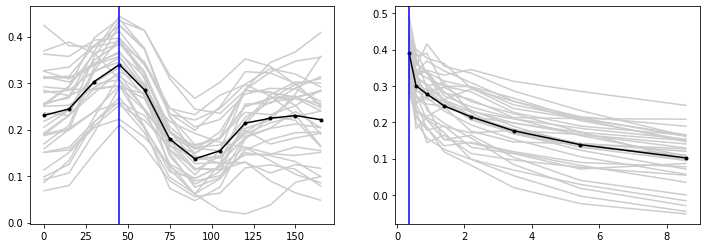

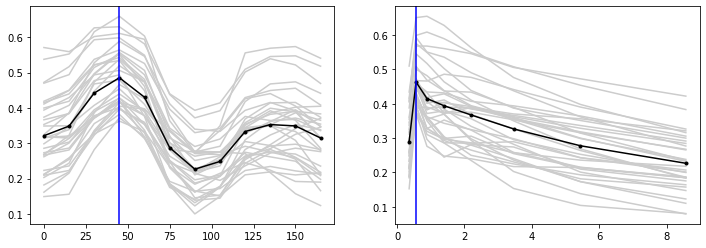

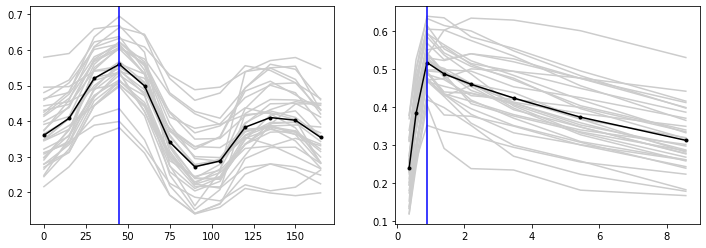

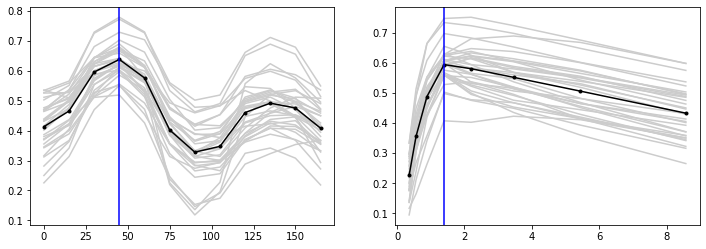

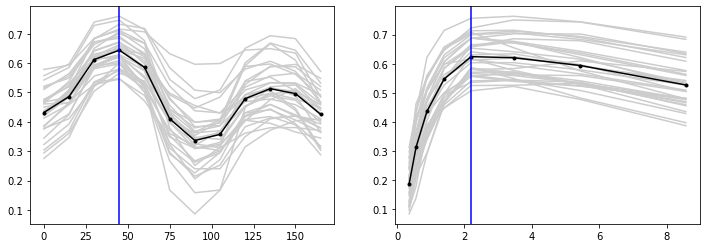

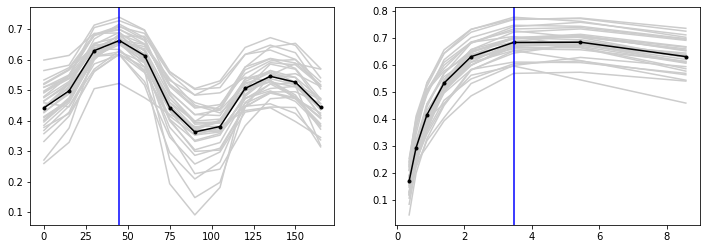

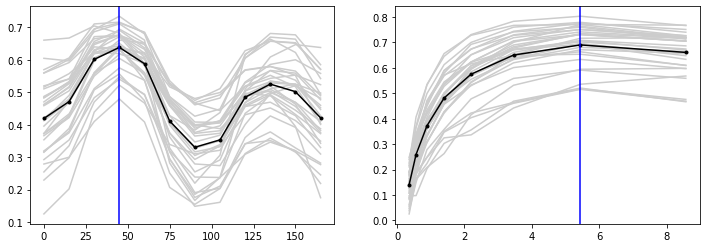

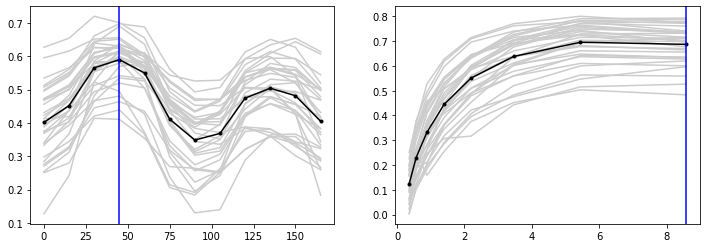

In [133]:
# fi = 0;
fi = 2;

size = np.unique(prf_pars[:,2])[0]

feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

ori = 45.0;
for sf in np.unique(sim_sf):

    vinds = (sim_orient==ori) & (sim_sf==sf)
    vinds = vinds & (prf_pars[:,2]==size)

    ori_tuning = mean_orient_corr[vinds,:]
    sf_tuning = mean_sf_corr[vinds,:]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(ori_unique, ori_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(ori_unique, np.mean(ori_tuning, axis=0), '.-',color='k')
    plt.axvline(ori, color='b')

    plt.subplot(1,2,2)
    plt.plot(sf_unique, sf_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(sf_unique, np.mean(sf_tuning, axis=0), '.-',color='k')
    plt.axvline(sf, color='b')


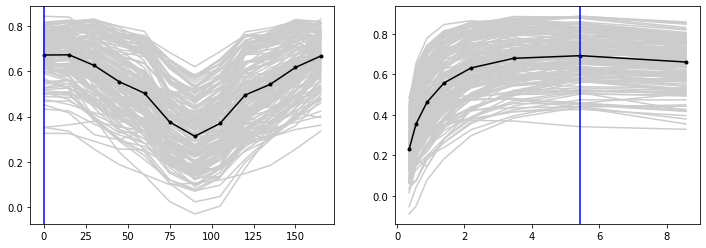

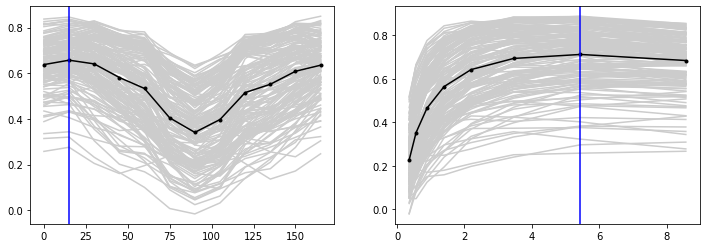

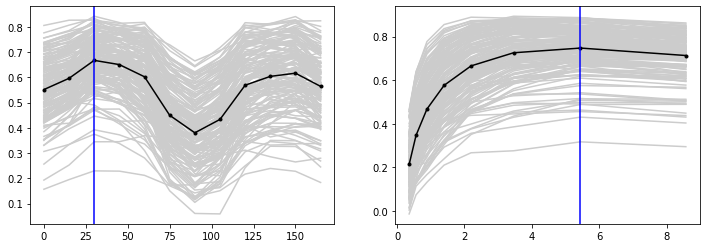

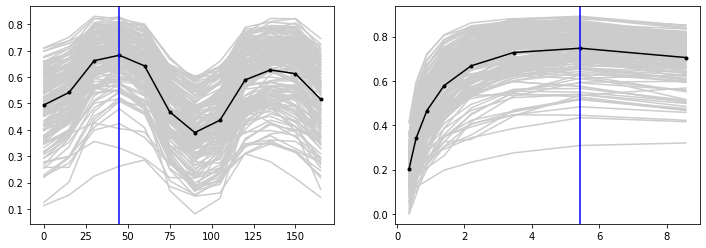

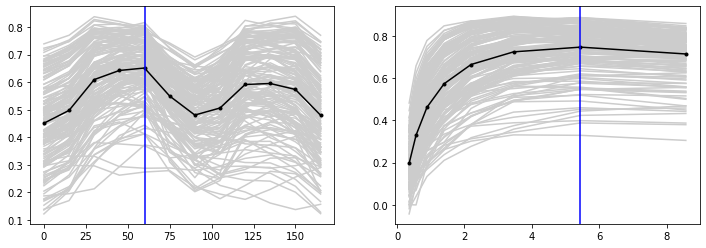

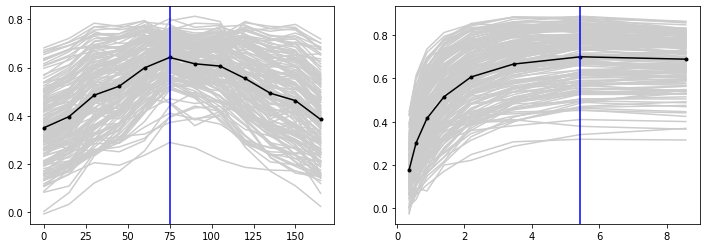

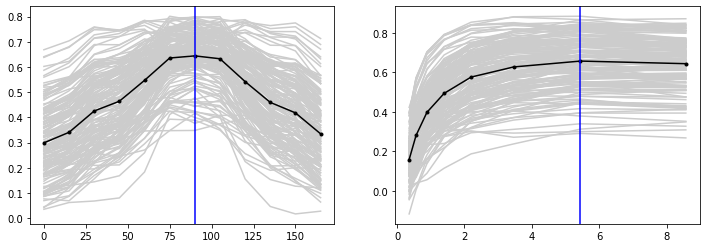

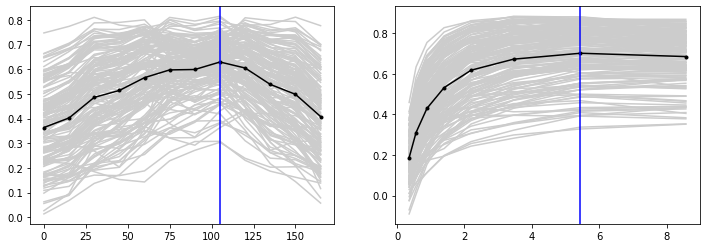

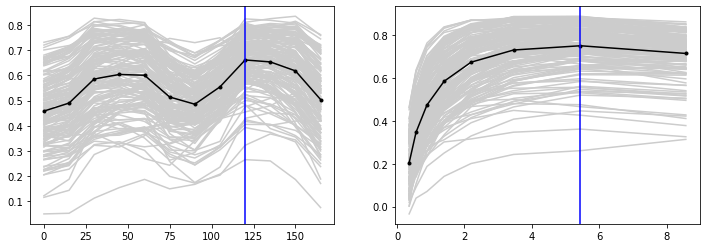

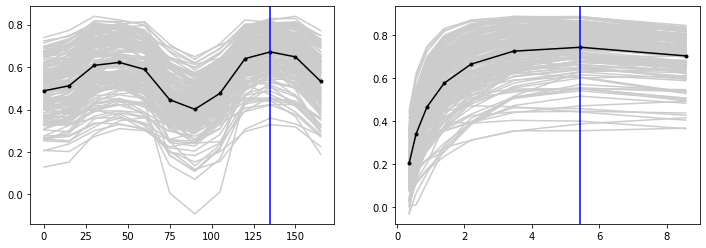

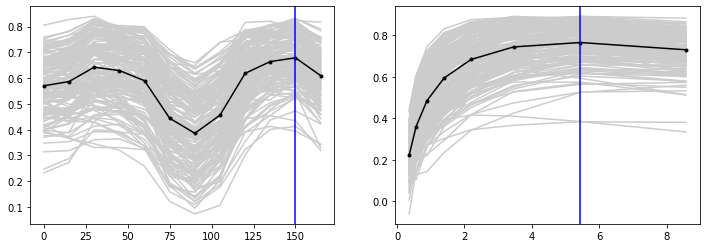

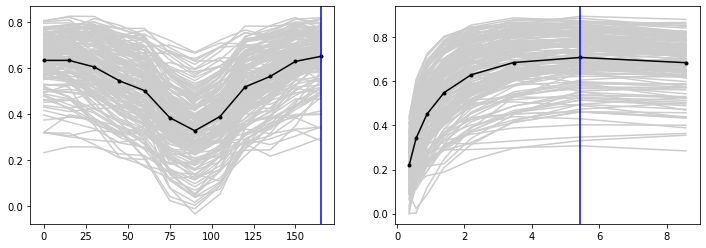

In [108]:
fi = 2;

feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

sf = np.unique(sim_sf)[-2]
for ori in np.unique(ori_unique):

    vinds = (sim_orient==ori) & (sim_sf==sf)

    ori_tuning = mean_orient_corr[vinds,:]
    sf_tuning = mean_sf_corr[vinds,:]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(ori_unique, ori_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(ori_unique, np.mean(ori_tuning, axis=0), '.-',color='k')
    plt.axvline(ori, color='b')

    plt.subplot(1,2,2)
    plt.plot(sf_unique, sf_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(sf_unique, np.mean(sf_tuning, axis=0), '.-',color='k')
    plt.axvline(sf, color='b')


In [18]:
preferred_ori_corr.shape

(15360,)

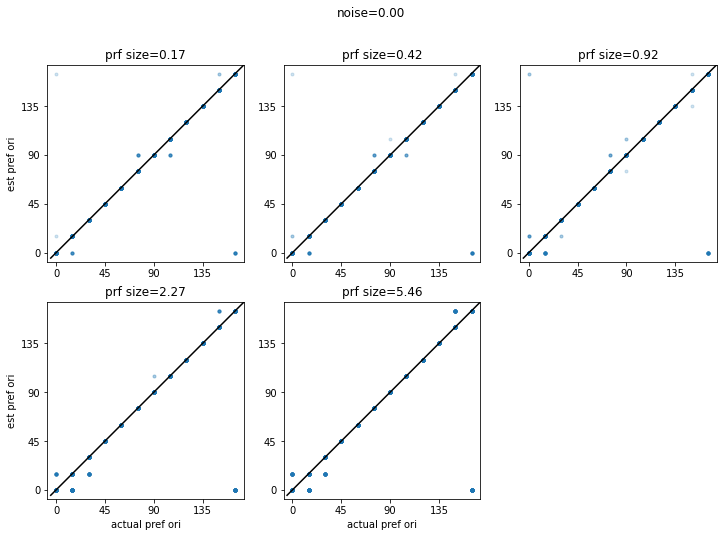

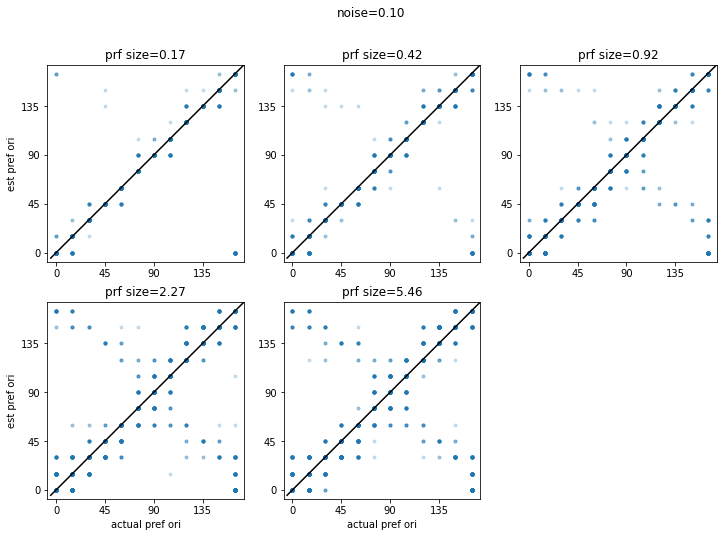

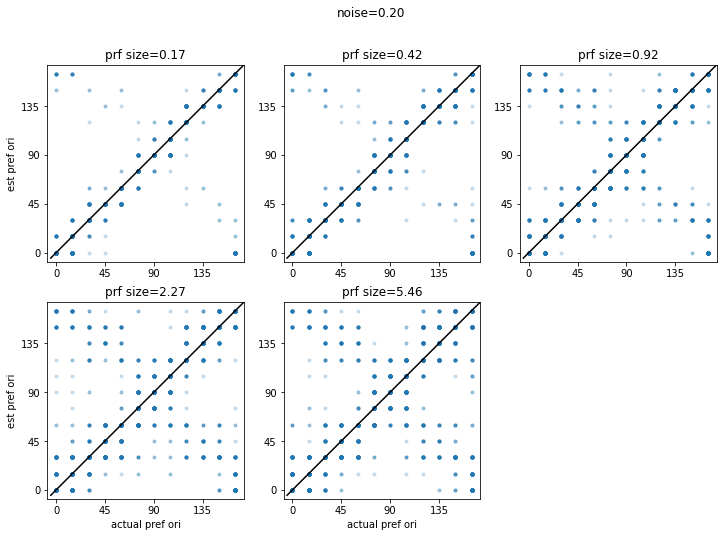

In [103]:
for fi, noise_level in enumerate(noise_levels):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,8))
    pi=0;
    est_orient = np.array(ori_unique)[preferred_ori_corr.astype(int)]
    for size in np.unique(prf_pars[:,2]):

        vox_inds = prf_pars[:,2]==size

        pi+=1
        plt.subplot(2,3,pi)
        plt.plot( sim_orient[vox_inds], est_orient[vox_inds], '.',alpha=0.2)
        plt.xticks(np.arange(0,180,45))
        plt.yticks(np.arange(0,180,45))
        plt.axis('square')
        lims = [-5, 180]
        plt.plot(lims, lims, color='k')
        plt.title('prf size=%.2f'%(size*8.4))
        if pi>3:
            plt.xlabel('actual pref ori')
        if np.mod(pi,3)==1:
            plt.ylabel('est pref ori')

    plt.suptitle('noise=%.2f'%noise_level)

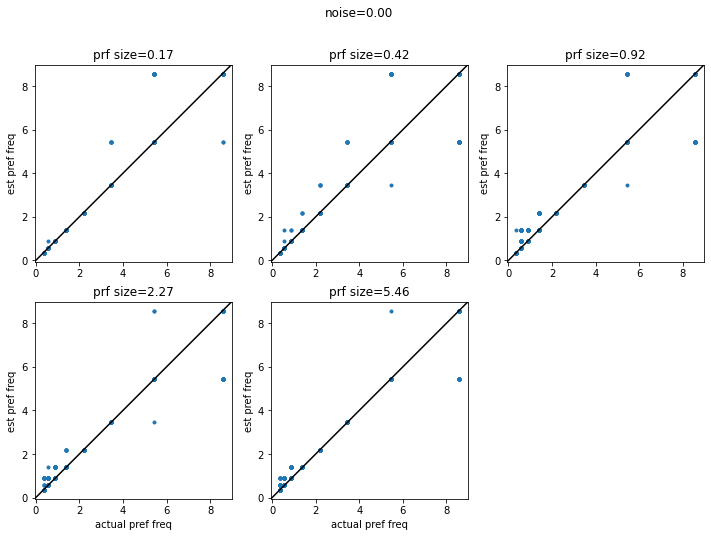

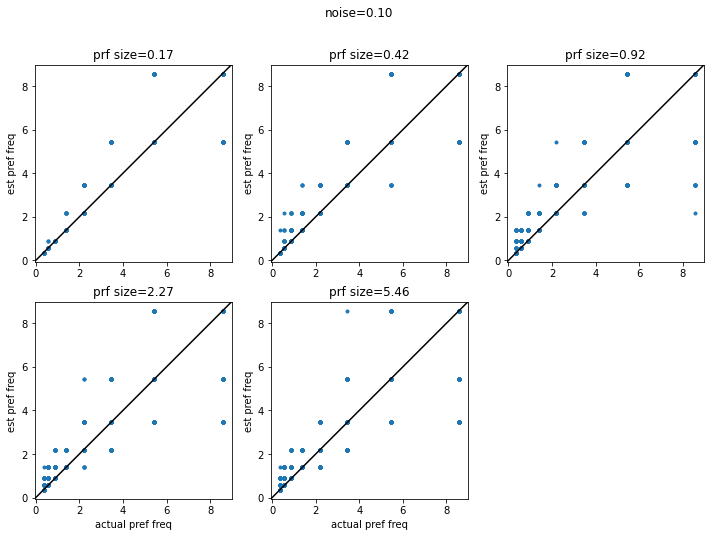

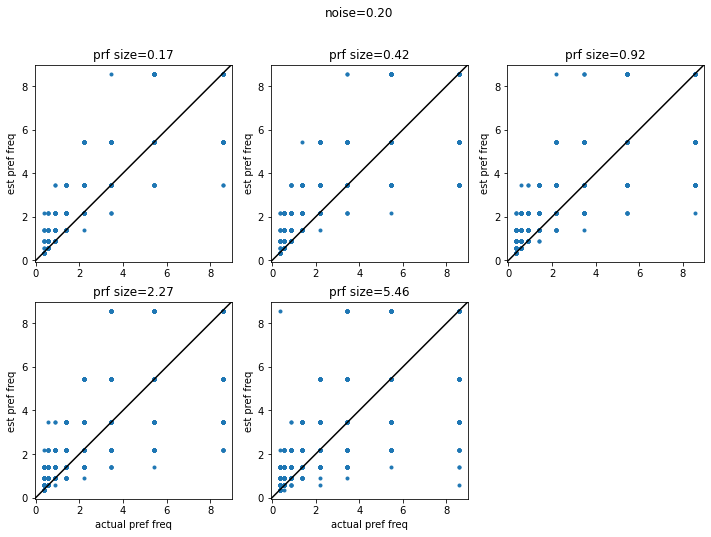

In [106]:
for fi, noise_level in enumerate(noise_levels):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,8))
    pi=0;
    est_sf = np.array(sf_unique)[preferred_sf_corr.astype(int)]
    for size in np.unique(prf_pars[:,2]):

        vox_inds = prf_pars[:,2]==size

        pi+=1
        plt.subplot(2,3,pi)
        plt.plot( sim_sf[vox_inds], est_sf[vox_inds], '.',alpha=1.0)
        # plt.xticks(sf_unique);
        # plt.yticks(sf_unique);
        plt.axis('square')
        lims = [-1,10]
        plt.plot(lims, lims, color='k')
        plt.title('prf size=%.2f'%(size*8.4))
        if pi>3:
            plt.xlabel('actual pref freq')
        plt.ylabel('est pref freq')
    
    plt.suptitle('noise=%.2f'%noise_level)